# Todo before I forget
* Fence plot
* Sed added per run like in Ferguson 2020
* Move underlayer routine in to plotPyVista.py

In [1]:
import numpy as np
import xarray as xr
import hvplot.xarray
import pyvista as pv
from JulesD3D.plotPyVista import makeStructuredGridUnderlayers
from JulesD3D.processNetCDF import fixCORs, fixMeshGrid
from JulesD3D.utils import quickDF, ncFilePicker, folderPicker, easyTimeFormat
from glob import glob
from os import path
import ipywidgets as widgets

In [2]:
pv.set_plot_theme("document") # for white background

# Thoughts
* depth_bedlayer is depth to bed (ie bottom of water)!
* The last nlyrp1 layer is the thick base layer

In [3]:
# folder = '/Users/julesblom/ThesisResults/Slope0.85'
folder = '/Users/julesblom/ThesisResults/Slope1.00'
# folder = '/Users/julesblom/ThesisResults/Slope1.25'

nc_filename = ncFilePicker(folder)

In [4]:
nc_filename

Select(description='NetCDF file:', layout=Layout(height='120px', width='100%'), options=('/Users/julesblom/The…

In [23]:
basename = path.basename(nc_filename.value)
plot_title, _ = path.splitext(basename)
plot_title
outputstep = -1

In [24]:
trim = xr.open_dataset(nc_filename.value)

In [25]:
for i in trim.LSED:
    print(i.values)

0
1


In [26]:
time_outputstep = trim.time.isel(time=outputstep).values
f"{plot_title}  {easyTimeFormat(time_outputstep)}"

2020-03-14T16:18:00.000000000


'Slope100_Run50  Day 14 — 16:18:00'

In [27]:
trim = fixCORs(trim)
trim = fixMeshGrid(trim, mystery_flag=True)

● Fixing mesh grid, assuming a uniform grid 
132 x 182 grid


Use the bedlayer depth/height to make the underlayer grid

In [28]:
plotting_options = dict(lighting=True, ambient=0.9, show_edges=False, specular=0.1, specular_power=1)
sargs = dict(
    title_font_size=20,
    label_font_size=16,
    shadow=True,
    n_labels=5,
    fmt="%.1f",
    font_family="arial",
)

In [29]:
underlayer_grid = makeStructuredGridUnderlayers(trim, time=-1)

Making StructuredGrid for underlayers at outputstep -1


Stack these to get (x, y, z) coordinates

## Add volume fraction sand to StructuredGrid
Should be flipped if you want to see deposit height. Delft3D writes depth of underlayer to file and we are taking heigh, so it needs to be flipped.

In [30]:
vol_frac_sand_at_time = trim.LYRFRAC.isel(time=-1, LSEDTOT=0).transpose('M', 'N', 'nlyr')
vol_frac_sand_at_time.shape

(132, 182, 77)

In [31]:
underlayer_grid["vol_frac_sand"] = vol_frac_sand_at_time.values.ravel()
underlayer_grid

StructuredGrid (0x124e3cc20)
  N Cells:	1802036
  N Points:	1849848
  X Bounds:	0.000e+00, 2.620e+04
  Y Bounds:	1.000e+02, 3.640e+04
  Z Bounds:	0.000e+00, 4.239e+00
  Dimensions:	77, 182, 132
  N Arrays:	2

## Add 'Mass of sand' to StructuredGrid

In [32]:
# = np.flip( , axis=2))
mass_sand_at_time = trim.MSED.isel(time=-1, LSEDTOT=0).transpose('M', 'N', 'nlyr')
mass_sand_at_time.shape

(132, 182, 77)

In [33]:
underlayer_grid["mass_sand"] = mass_sand_at_time.values.ravel()
underlayer_grid

StructuredGrid (0x124e3cc20)
  N Cells:	1802036
  N Points:	1849848
  X Bounds:	0.000e+00, 2.620e+04
  Y Bounds:	1.000e+02, 3.640e+04
  Z Bounds:	0.000e+00, 4.239e+00
  Dimensions:	77, 182, 132
  N Arrays:	2

In [34]:
contours = underlayer_grid.contour()

2020-03-14T16:18:00.000000000


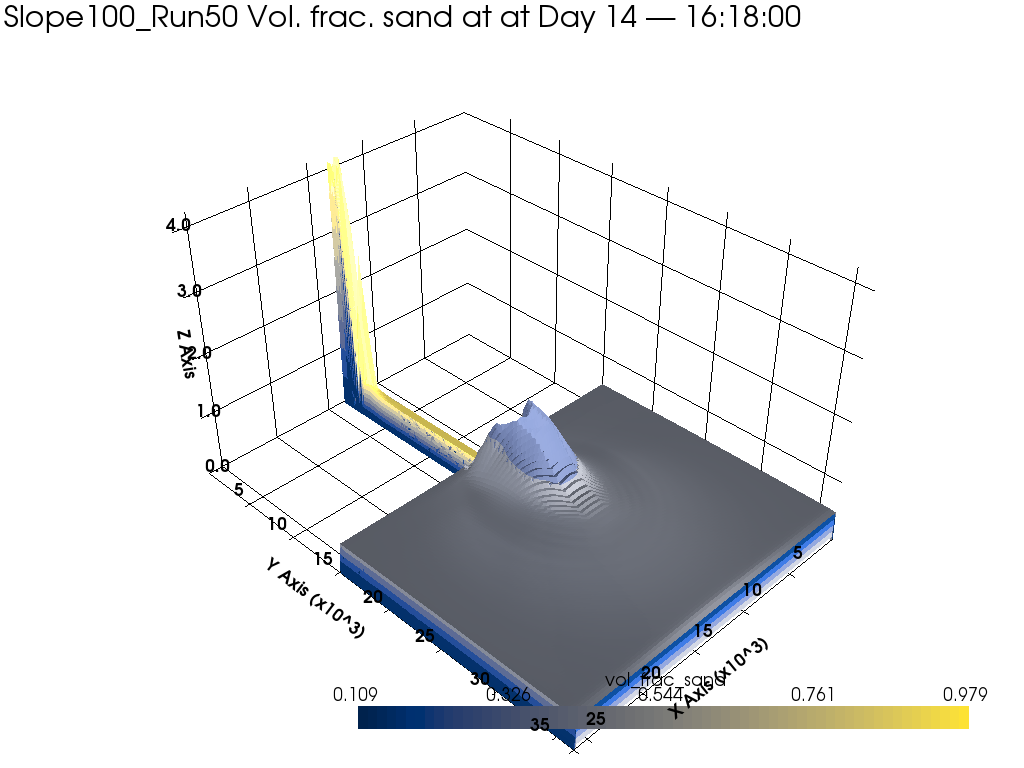

In [41]:
p = pv.Plotter(notebook=True)
p.add_mesh(contours, scalars='vol_frac_sand', cmap='cividis', interpolate_before_map=False, **plotting_options)
# p.add_mesh(contours, color="white", line_width=5)
p.show_grid()
p.add_text(f"{plot_title} Vol. frac. sand at at {easyTimeFormat(time_outputstep)}", position='upper_left')
p.set_scale(zscale=5000)
p.show()

# Plot Volume Fraction of Sand at End

2020-03-14T16:18:00.000000000


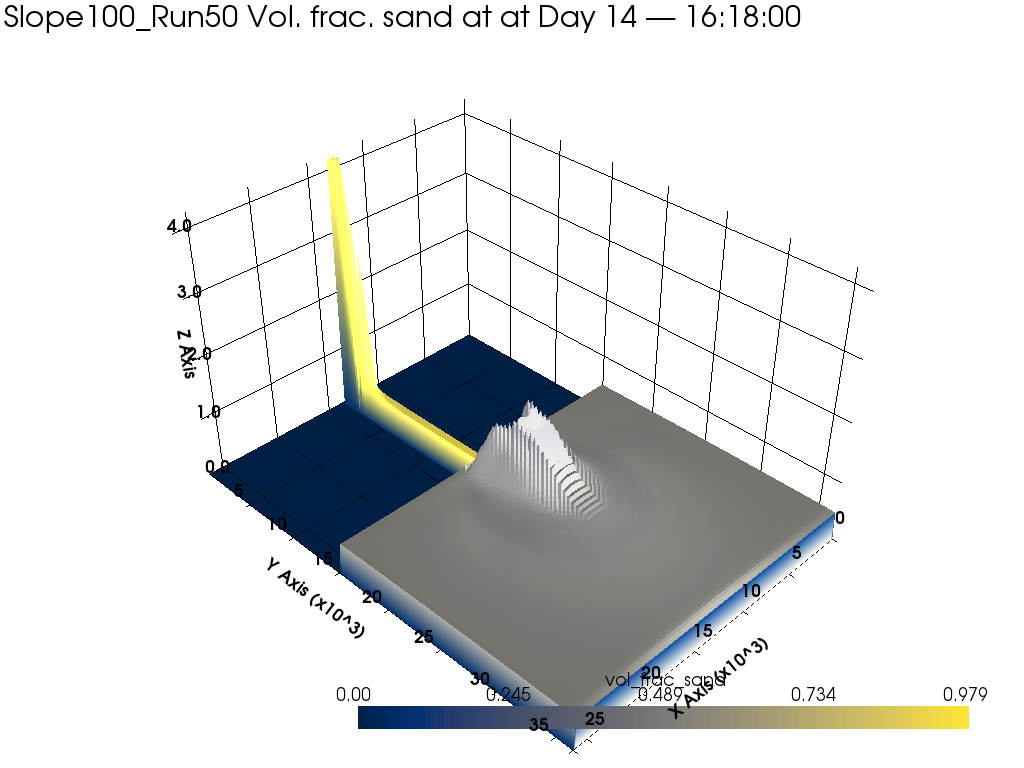

In [36]:
p = pv.Plotter(notebook=True)
p.add_mesh(underlayer_grid, scalars='vol_frac_sand', cmap='cividis', interpolate_before_map=False, **plotting_options)
# p.add_mesh(contours, color="white", line_width=5)
p.show_grid()
p.add_text(f"{plot_title} Vol. frac. sand at at {easyTimeFormat(time_outputstep)}", position='upper_left')
p.set_scale(zscale=5000)
p.show()

# Plot Mass of Sand  at End

In [37]:
mass_sand_clim = [100, 600]

2020-03-14T16:18:00.000000000


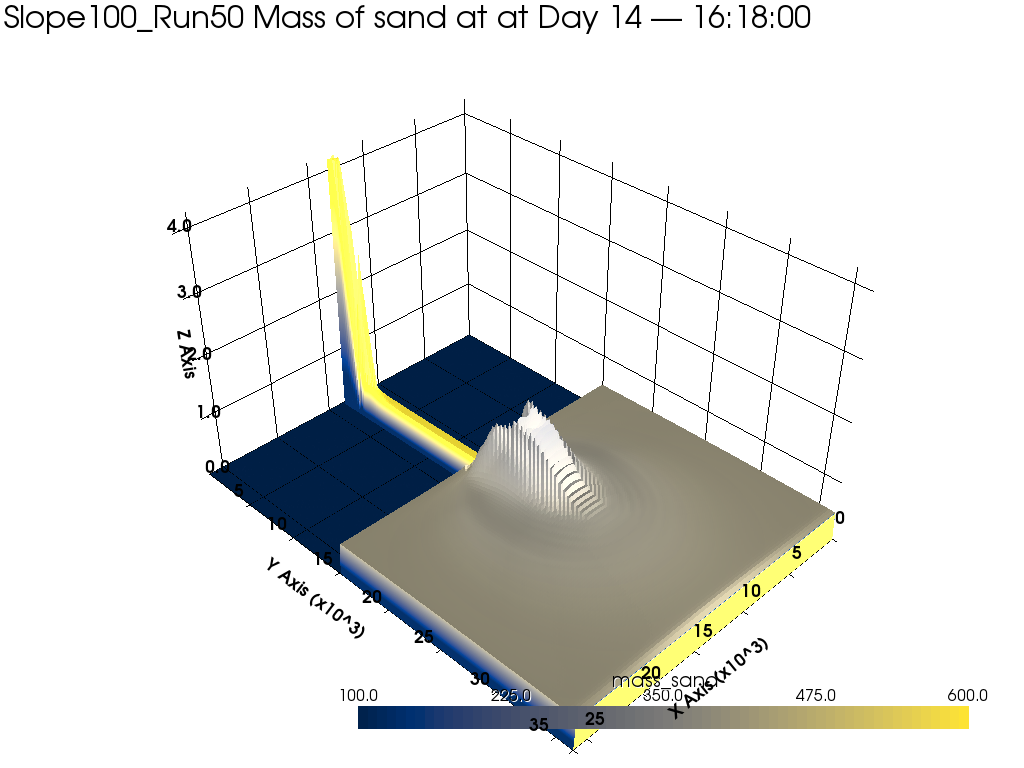

In [38]:
p = pv.Plotter(notebook=True)
p.add_mesh(underlayer_grid, scalars='mass_sand', cmap='cividis', **plotting_options, clim=mass_sand_clim,  
           scalar_bar_args=sargs)#show_edges=True, edge_color='white')
p.add_text(f"{plot_title} Mass of sand at at {easyTimeFormat(time_outputstep)}", position='upper_left')
p.show_grid()
p.set_scale(zscale=5000)
p.show() #screenshot="output_material/MassOfSandUnderlayer.png")

# Cool PyVista plotting stuff

## Slices / Fence plot

In [39]:
underlayer_slices_y = underlayer_grid.slice_along_axis(n=30, axis="y")
underlayer_slices_x = underlayer_grid.slice_along_axis(n=15, axis="x")

In [40]:
p = pv.Plotter(notebook=False)
p.add_mesh(underlayer_slices_x, scalars='vol_frac_sand', cmap="cividis", opacity=0.9, ambient=0.3)
p.add_mesh(underlayer_slices_y, scalars='vol_frac_sand', cmap="cividis", opacity=0.9, ambient=0.3)
p.enable_depth_peeling(10)
p.add_text(f"Underlayer slices sand fraction at {easyTimeFormat(time_outputstep)}", position='upper_left')
p.show_grid()
p.set_scale(zscale=5000)
p.show()

2020-03-14T16:18:00.000000000


[(72408.6846137522, 19936.70728018968, 3.9287873527463835),
 (19251.06767835177, 17667.332009823993, 2.111763509139573),
 (-0.17313020890950967, 0.1758095384966797, 0.9690804594751325)]